In [34]:
import os
import logging
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import tqdm

import sklearn.manifold as sm
import sklearn.decomposition as sd
import sklearn.model_selection as ms
import sklearn.preprocessing as spr
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import sklearn.metrics as sx
import sklearn.calibration as sc

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)
%matplotlib inline
sns.set()

p = print

In [65]:
price = pd.read_csv("../data/hitbtcUSD.csv")
price.columns = ['ts', 'price', 'volume']
price = price.assign(ts=price.astype(int))\
.assign(date=pd.to_datetime(price.ts, unit='s'))
price = price.set_index('date')

In [66]:
price.head(2)

,ts,price,volume
date,,,
2013-12-27 08:24:07,1388132647,778.0,0.2
2013-12-27 08:25:37,1388132737,778.0,0.2


In [67]:
def resample_ohlc(_df, period, min_date=None, dropna=True):
    if min_date:
        z = _df[_df.index > min_date]
    else:
        z = _df
    res = z.resample(period).ohlc()
    if dropna:
        res = res.dropna()
    return res

In [68]:
ohlc_1day = resample_ohlc(price[['price', 'volume']], '1d', min_date='2017-08-01')
ohlc_1hour = resample_ohlc(price[['price', 'volume']], '1h', min_date='2017-08-01')
ohlc_30min = resample_ohlc(price[['price', 'volume']], '30min', min_date='2017-08-01')

In [ ]:
def featurize_v1(_df):
    nshifts = 3
    target = _df.price.open > _df.price.close
    f1 = _df.price.open - _df.price.close
    f2 = _df.price.high - _df.price.low    
    _x = np.column_stack([f1.shift(-1),f2.shift(-1), f1.shift(-2),f2.shift(-2),f1.shift(-3),f2.shift(-3)])
    return target[:-nshifts].astype(int), _x[:-nshifts]

y, X = featurize_v1(ohlc_1hour)

In [ ]:
X_train, X_test, y_train, y_test = ms.train_test_split(sm.add_constant(X, prepend=False), y)
lr = sm.Logit(y_train, X_train).fit(refit=False) 
lr.summary2()

In [10]:
n_splits = 5
n_repeats = 30
rkf = ms.RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
classifier_stats = []

for train_index, test_index in tqdm.tqdm_notebook(rkf.split(sm.add_constant(X,prepend=False)), total=n_splits*n_repeats):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    lr = sm.Logit(y_train, X_train).fit_regularized(refit=True)    
    pred = lr.predict(X_test)    
    classifier_stats.append({
        'roc_auc': sx.roc_auc_score(y_true=y_test, y_score=pred),
        'acc_score': sx.accuracy_score(y_true=y_test, y_pred=pred>0.5)
        }
    )

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6899799083150149
            Iterations: 10
            Function evaluations: 28
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6915238907334637
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6903947622416869
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6915695140695349
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6912325948625307
            Iterations: 9
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6902711051875193
            Iterations: 10
            Function evaluations: 28
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.691811421388597
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6917690219811445
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6909256701996952
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6912711559099801
            Iterations: 9
            Function evalua

            Current function value: 0.6914661054418443
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6910219322117795
            Iterations: 10
            Function evaluations: 29
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6917877227458109
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6916154489953408
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.690099392457836
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 9
Optimizat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6914446731957631
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6909964752570807
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.691869441220005
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6915421075948134
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6905016041194795
            Iterations: 9
            Function evaluati

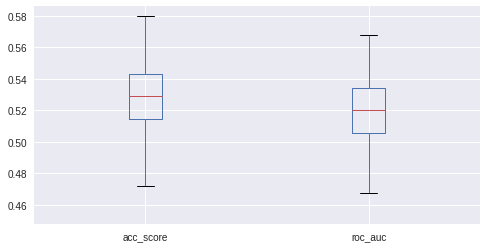

In [11]:
pd.DataFrame(classifier_stats).boxplot(figsize=(8,4))
pass

In [4]:
def wilson(p, n, z=1.96):
    return z * np.sqrt((p * (1 - p) + z * z / (4 * n)) / n) / (1 + z * z / n)

n_bins=10
T_test_pred = lr.predict(X_test)
p_true, p_pred = sc.calibration_curve(y_test, 
                                      T_test_pred, 
                                      n_bins=n_bins)

bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
binids = np.digitize(T_test_pred, bins) - 1
bin_total = np.bincount(binids, minlength=len(bins))
ci = wilson(p_true, bin_total[bin_total != 0])

fig, ax = pl.subplots(figsize=(5, 5))
ax.plot(p_pred, p_true)
ax.fill_between(p_pred, p_true-ci, p_true+ci, alpha=0.1)
ax.set_xlim(0, 1)
ax.set_xlabel("$P_{pred}$")
ax.set_ylim(0, 1)
ax.set_ylabel("$P_{true}$")
print()

NameError: name 'lr' is not defined

In [5]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

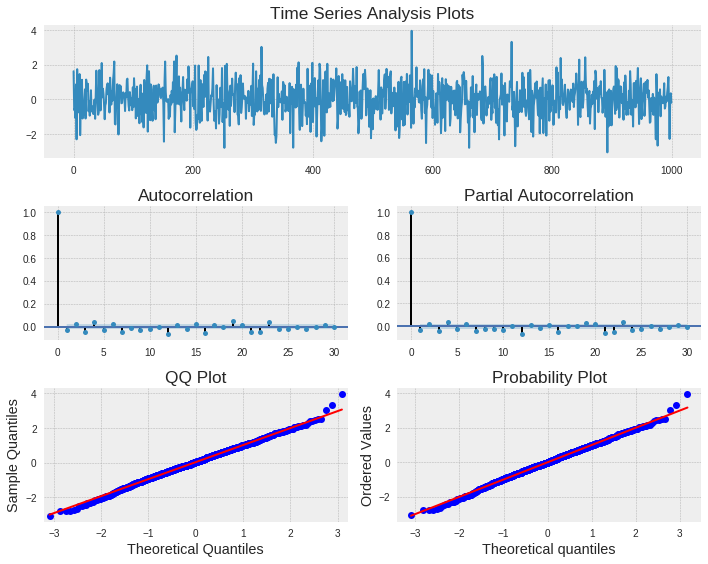

In [7]:
np.random.seed(1)
# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

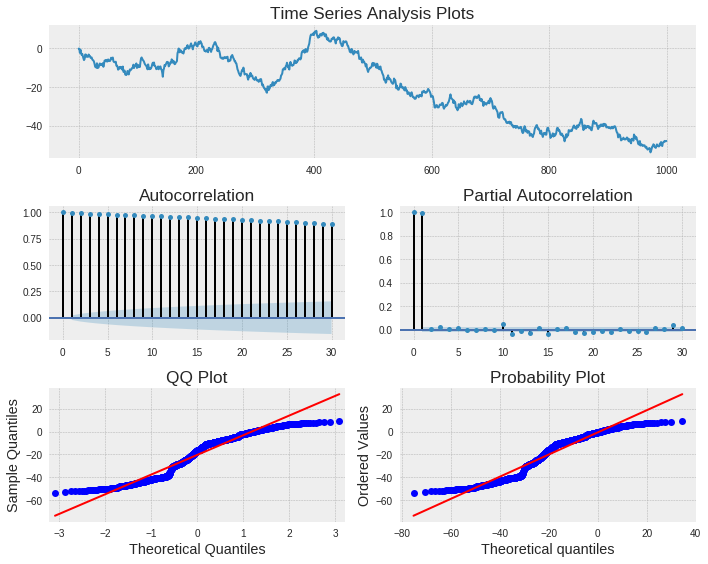

In [26]:
# Random Walk without a drift
lags=30
np.random.seed(2)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=lags)

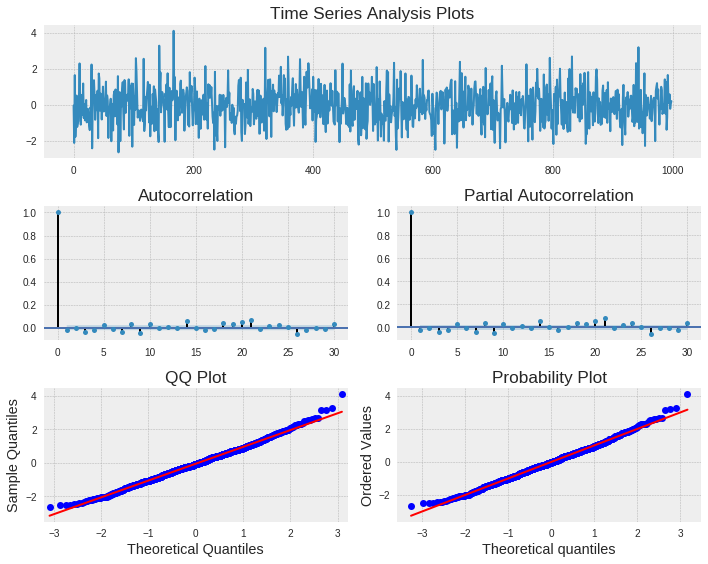

In [12]:
_ = tsplot(np.diff(x), lags=30)

# 1 hour time series

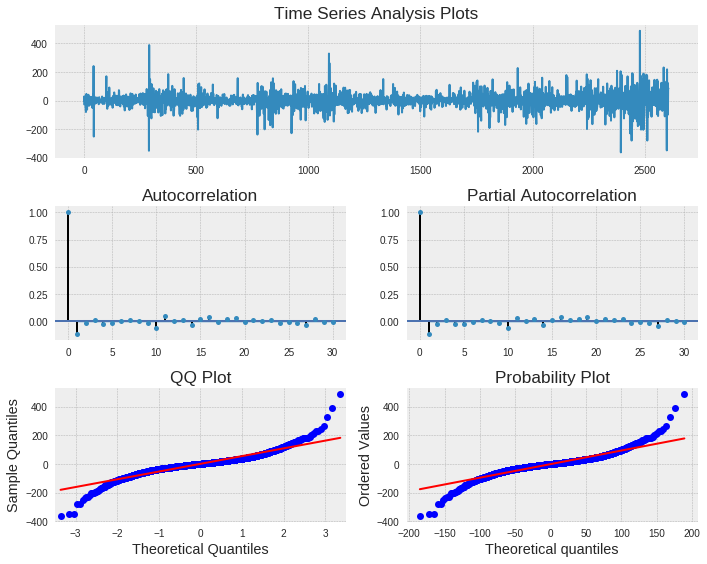

In [27]:
_ = tsplot(np.diff(ohlc_1hour.price.open), lags=lags)

# 1h Log returns

In [59]:
logreturn_1h  = np.log(ohlc_1hour.price.open /ohlc_1hour.price.open.shift(1)).dropna()

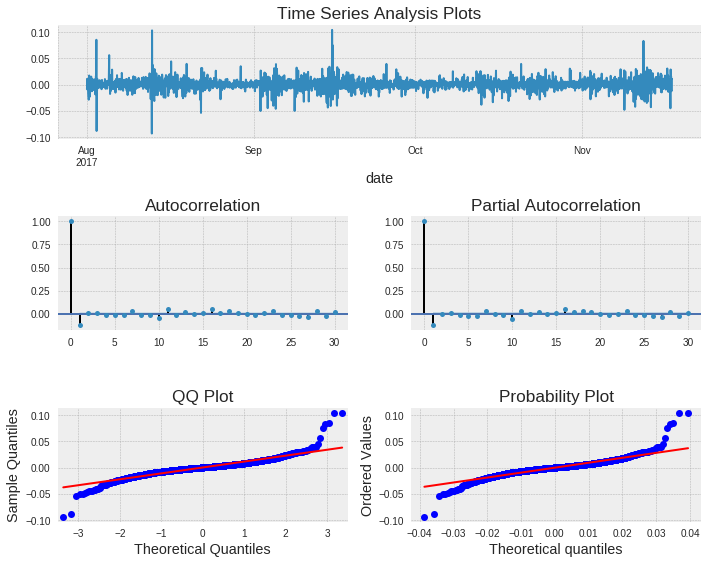

In [61]:
tsplot(logreturn_1h, lags=lags)

# Fit ARMA to log returns

In [75]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(8)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(logreturn_1h, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-p

aic: -16031.28163 | order: (3, 3)


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [77]:
best_mdl.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: ARMA
=====================================================================
Model:              ARMA             BIC:                 -15990.2199
Dependent Variable: open             Log-Likelihood:      8022.6     
Date:               2017-12-17 22:01 Scale:               1.0000     
No. Observations:   2607             Method:              mle        
Df Model:           6                Sample:              08-01-2017 
Df Residuals:       2601                                  11-17-2017 
Converged:          0.0000           S.D. of innovations: 0.011      
AIC:                -16031.2816      HQIC:                -16016.406 
-----------------------------------------------------------------------
              Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-----------------------------------------------------------------------
ar.L1.open    0.6648     0.1648     4.0340   0.0001    0.3418    0.9879
ar.L2.open   -0.9922     0.0930   -10.6729   0.0000   -1.1744   -0.8100
ar.L3.open    0.0543     0.1684     0.3227   0.7470   -0.2757    0.3844
ma.L1.open   -0.7904     0.1614    -4.8955   0.0000   -1.1068   -0.4739
ma.L2.open    1.0894     0.0922    11.8160   0.0000    0.9087    1.2701
ma.L3.open   -0.1860     0.1664    -1.1176   0.2639   -0.5122    0.1402
------------------------------------------------------------------------------
                  Real           Imaginary          Modulus          Frequency
------------------------------------------------------------------------------
AR.1             0.3175            -0.9713           1.0219            -0.1997
AR.2             0.3175             0.9713           1.0219             0.1997
AR.3            17.6213            -0.0000          17.6213            -0.0000
MA.1             0.3075            -0.9649           1.0127            -0.2009
MA.2             0.3075             0.9649           1.0127             0.2009
MA.3             5.2422            -0.0000           5.2422            -0.0000
=====================================================================

"""

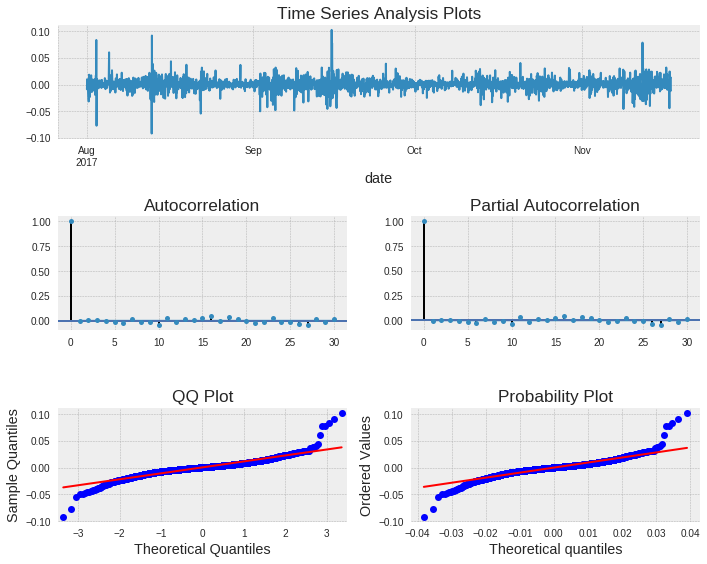

In [82]:
_ = tsplot(best_mdl.resid, lags=lags)

### Making forecast with the best model we have

In [85]:
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(logreturn_1h.index[-1], periods=n_steps, freq='h')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2017-11-17 15:00:00,0.000581,-0.021272,-0.028139,0.022434,0.029301
2017-11-17 16:00:00,0.001815,-0.020209,-0.027130,0.023840,0.030761
2017-11-17 17:00:00,-0.001143,-0.023170,-0.030091,0.020884,0.027805
2017-11-17 18:00:00,-0.002530,-0.024557,-0.031478,0.019497,0.026419
2017-11-17 19:00:00,-0.000449,-0.022480,-0.029402,0.021582,0.028505
2017-11-17 20:00:00,0.002149,-0.019884,-0.026807,0.024182,0.031105
2017-11-17 21:00:00,0.001737,-0.020297,-0.027221,0.023771,0.030694
2017-11-17 22:00:00,-0.001002,-0.023040,-0.029965,0.021036,0.027961
2017-11-17 23:00:00,-0.002273,-0.024311,-0.031236,0.019766,0.026690
2017-11-18 00:00:00,-0.000422,-0.022464,-0.029389,0.021619,0.028545


## Using ARIMA

In [87]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [88]:
res_tup = _get_best_model(logreturn_1h)

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

aic: -16031.28163 | order: (3, 0, 3)


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


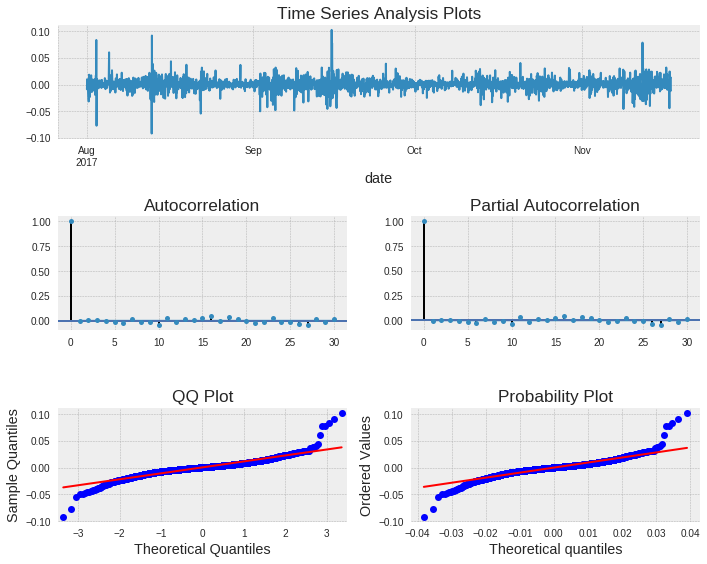

In [91]:
tsplot(res_tup[2].resid, lags=lags) # order 3 0 3 

In [94]:
order = res_tup[1]
p_ = order[0]
o_ = order[1]
q_ = order[2]
TS = logreturn_1h
# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         open   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                7627.37
Distribution:      Standardized Student's t   AIC:                          -15236.7
Method:                  Maximum Likelihood   BIC:                          -15184.0
                                              No. Observations:                 2607
Date:                      Sun, Dec 17 2017   Df Residuals:                     2598
Time:                              22:23:52   Df Model:                            9
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

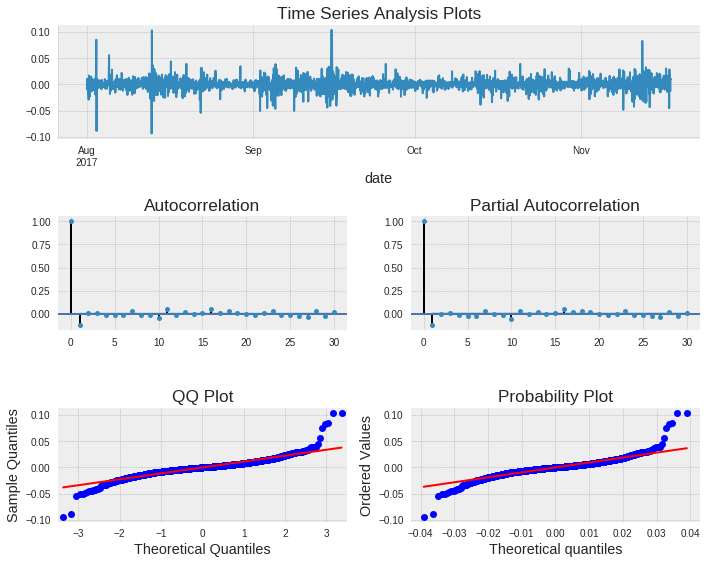

In [95]:
_= tsplot(res.resid,lags=lags)

### ---- 

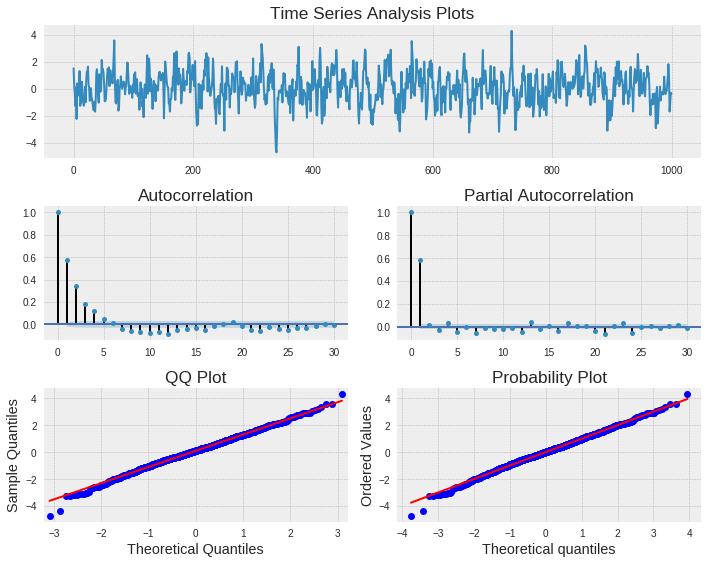

In [28]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=lags)

In [32]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
true_order = 1

In [31]:
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

CPU times: user 22.9 s, sys: 20.2 s, total: 43.2 s
Wall time: 21.9 s


In [36]:
p('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'.format(a, true_order))


alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


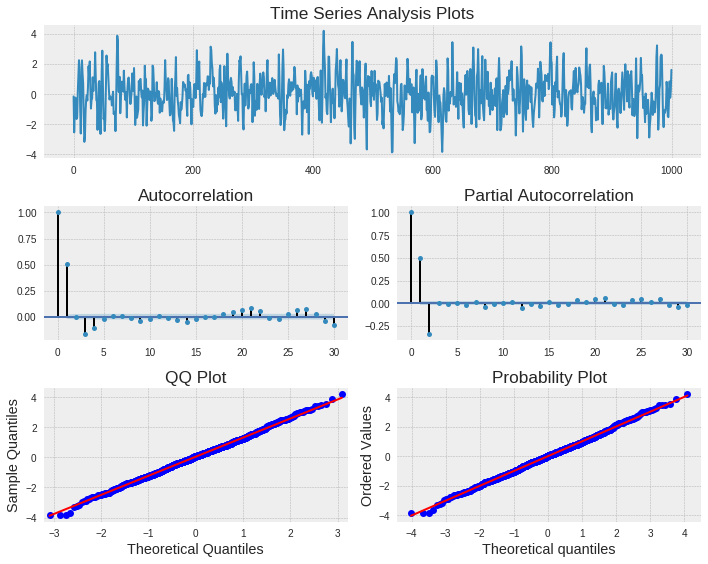

In [46]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=lags)

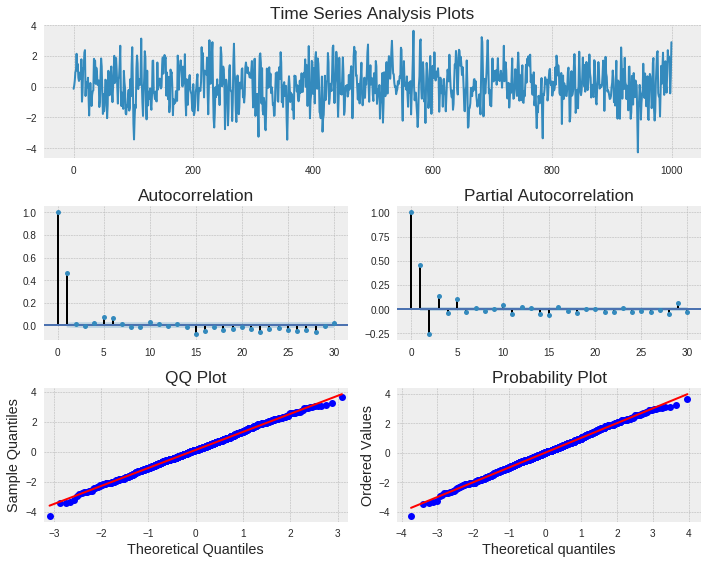

In [57]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [58]:
max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1438.725
Method:                           mle   S.D. of innovations              1.020
Date:                Sun, 17 Dec 2017   AIC                           2881.451
Time:                        21:48:24   BIC                           2891.266
Sample:                             0   HQIC                          2885.182
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6214      0.024     26.074      0.000       0.575       0.668
                                    Roots                                    
                 Real           Imaginary           M